## 1 - Packages

In [16]:
import numpy as np
import matplotlib.pyplot as plt

## 2 - Overview of the Problem set

**Problem Statement**: A gardener has 140 feet of fencing to fence in a rectangular vegetable garden. The gardener wants to know the dimensions of the largest area he can fence.

We will help the gardener to find the optimal dimensions that give him the largest area to fence using genetic algorithm.

Let's go!

We all know that the area of a rectangular is

                            area = width x length                     (1)
                            
Also, we know the perimeter is fixed at 140 ft

                            perimeter = 2*width + 2*length = 140
                            width + length = 70
                            width = 70 - length                       (2)
                            
Now, if substitute equation (2) in equation (1) we get

                            area = (70 - length) x length
                            area = 70*length - length^2               (3)
                            
Finally, if we want to maximize the area we need to find the optimal value for length variable. As we all know, equation (3) is a quadratic function in one variable therefor we can draw the function and find the optimal value for length but we want to find the optimal value using
genetic algorithm :)          

## 3 - Finding optimal value using graph

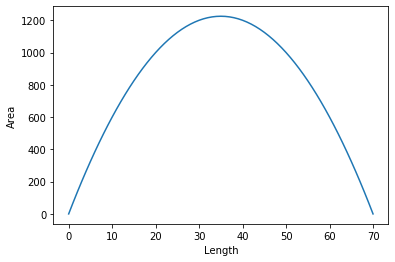

In [17]:
length = np.linspace(0, 70, 71)
area = 70*length - np.power(length, 2)
plt.xlabel("Length")
plt.ylabel("Area")
plt.plot(length, area)

In [18]:
print(f'The maximum area = {np.max(area)}')
print(f'The optimal dimensions at length={np.argmax(area)} and width={70-np.argmax(area)}')

The maximum area = 1225.0
The optimal dimensions at length=35 and width=35


## 4 - Finding optimal value using genetic algorithm

In [19]:
def encode_chrom(value):
    chrom = np.unpackbits(value)
    return chrom

encode_chrom(np.array([3], dtype=np.uint8))

array([0, 0, 0, 0, 0, 0, 1, 1], dtype=uint8)

In [20]:
def decode_chrom(chrom):
    chrom_value = np.packbits(chrom)[0]
    length = chrom_value*70/255
    return length

chrom = encode_chrom(np.array([255], dtype=np.uint8))
decode_chrom(chrom)

70.0

In [21]:
def compute_fitness(chrom):
    length = decode_chrom(chrom)
    fitness = 70*length - np.power(length, 2)
    return fitness

chrom = encode_chrom(np.array([128], dtype=np.uint8))
decode_chrom(chrom), compute_fitness(chrom)

(35.13725490196079, 1224.9811610918878)

In [22]:
def init_population(chroms_num, start, end):
    genes_num=8
    population = np.zeros((chroms_num, genes_num), dtype=np.uint8)
    for i in range(chroms_num):
        chrom_value = np.random.randint(low=start, high=end+1, dtype=np.uint8)
        chrom = encode_chrom(chrom_value)
        population[i] = chrom
    return population

np.random.seed(42)
population = init_population(chroms_num=10, start=0, end=70)
print(f"Population: \n{population}")

Population: 
[[0 0 1 1 0 0 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 1 1 1 0]
 [0 0 1 1 1 0 1 1]
 [0 0 0 1 1 0 0 1]
 [0 0 1 1 1 1 0 0]
 [0 0 0 1 0 1 0 0]
 [0 0 1 0 0 1 1 1]
 [0 0 0 1 1 0 0 0]
 [0 1 0 0 0 0 0 1]]


In [23]:
def compute_pop_fitness(population):
    pop_fitness = np.zeros((population.shape[0], 1))
    for idx, chrom in enumerate(population):
        fitness = compute_fitness(chrom)
        pop_fitness[idx] = fitness
    return pop_fitness

np.random.seed(42)
population = init_population(chroms_num=10, start=0, end=70)
pop_fitness = compute_pop_fitness(population)
print(f"Population fitness: \n{pop_fitness}")

Population fitness: 
[[784.        ]
 [ 56.96885813]
 [254.24990388]
 [871.41253364]
 [433.29488658]
 [881.66089965]
 [354.17147251]
 [634.79584775]
 [417.7716263 ]
 [930.64206075]]


In [24]:
def roulette_wheel_selection(population, fitness, parents_num):
    chroms_num, genes_num = population.shape
    # Create roulette wheel for chroms selection
    probs = fitness/np.sum(fitness)
    probs_start = np.zeros(probs.shape)
    probs_end = np.zeros(probs.shape)
    current = 0
    for i in range(chroms_num): 
        probs_start[i] = current
        probs_end[i] = current + probs[i]
        current = probs_end[i]
    # Select chroms in the current generation as parents for mating
    parents = np.zeros((parents_num, genes_num), dtype=np.uint8)
    for parent_idx in range(parents_num):
        arrow = np.random.rand()
        for chrom_idx in range(chroms_num):
            if arrow >= probs_start[chrom_idx] and arrow < probs_end[chrom_idx]:
                parents[parent_idx, :] = population[chrom_idx, :]
                break
    return parents

np.random.seed(42)
population = init_population(chroms_num=10, start=0, end=70)
pop_fitness = compute_pop_fitness(population)
parents = roulette_wheel_selection(population, pop_fitness, parents_num=4)
parents

array([[0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1]], dtype=uint8)

In [25]:
def crossover(parents, offsprings_num):
    parents_num, genes_num = parents.shape
    offsprings_num = (np.ceil(offsprings_num/2)*2).astype(np.uint8)
    offsprings = np.zeros((offsprings_num, genes_num), dtype=np.uint8)
    crossover_prob = 0.8
    for i in range(0, offsprings_num, 2):
        parents_idx = np.random.permutation(parents_num)
        if np.random.rand() <= crossover_prob: 
            crossover_point = np.random.randint(low=1, high=genes_num)
            # First child
            offsprings[i, :crossover_point] = parents[parents_idx[0], :crossover_point]
            offsprings[i, crossover_point:] = parents[parents_idx[1], crossover_point:]
            # Second child
            offsprings[i+1, :crossover_point] = parents[parents_idx[1], :crossover_point]
            offsprings[i+1, crossover_point:] = parents[parents_idx[0], crossover_point:]
        else:
            offsprings[i, :] = parents[parents_idx[0],:]
            offsprings[i+1, :] = parents[parents_idx[1],:]
    return offsprings

np.random.seed(42)
population = init_population(chroms_num=10, start=0, end=70)
pop_fitness = compute_pop_fitness(population)
parents = roulette_wheel_selection(population, pop_fitness, parents_num=4)
offsprings = crossover(parents, population.shape[0])
offsprings

array([[0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1]], dtype=uint8)

In [26]:
def mutation(offsprings):
    offsprings_num, genes_num = offsprings.shape
    mutation_prob = 0.01
    for idx in range(offsprings_num):
        if np.random.rand() <= mutation_prob: 
            gene = np.random.randint(low=0, high=genes_num)
            offsprings[idx, gene] = 1 - offsprings[idx, gene]
    return offsprings

np.random.seed(42)
population = init_population(chroms_num=10, start=0, end=70)
pop_fitness = compute_pop_fitness(population)
parents = roulette_wheel_selection(population, pop_fitness, parents_num=4)
offsprings = crossover(parents, population.shape[0])
new_population = mutation(offsprings)
new_population

array([[0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1]], dtype=uint8)

In [27]:
def run(population, generations_num=500, parents_num=4):
    history = []
    for generation in range(generations_num):
        pop_fitness = compute_pop_fitness(population)
        history.append(np.max(pop_fitness))
        parents = roulette_wheel_selection(population, pop_fitness, parents_num)
        offsprings = crossover(parents, offsprings_num=population.shape[0])
        population = mutation(offsprings)
    history.append(np.max(compute_pop_fitness(population)))
    return population, history

In [28]:
np.random.seed(42)
chroms_num = 10
population = init_population(chroms_num, 0, 70)
population, history = run(population, generations_num=500, parents_num=4)
pop_fitness = compute_pop_fitness(population)
best_chrom_idx = np.argmax(pop_fitness)
length = round(decode_chrom(population[best_chrom_idx, :]))
width = 70 - length
print(f"Optimal length = {length} and Width = {width}")
print(f"Maximum area = {length*width}")

Optimal length = 35.0 and Width = 35.0
Maximum area = 1225.0


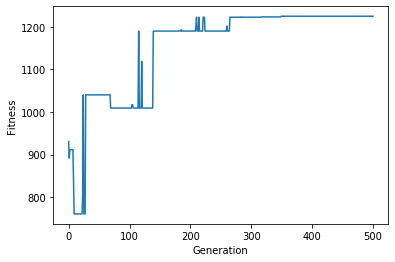

Maximum area = 1225.0


In [29]:
def plot_result(history):
    plt.plot(history)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()
    
plot_result(history)
print(f"Maximum area = {round(np.max(history))}")

In [30]:
np.random.seed(42)
chroms_num = 10
lengths = []
for _ in range(50):
    population = init_population(chroms_num, 0, 70)
    population, history = run(population, generations_num=500, parents_num=4)
    pop_fitness = compute_pop_fitness(population)
    best_chrom_idx = np.argmax(pop_fitness)
    length = round(decode_chrom(population[best_chrom_idx, :]))
    lengths.append(length)
    
from collections import Counter
counter = Counter(lengths)
print(counter.most_common(5))

[(35.0, 4), (31.0, 4), (32.0, 4), (23.0, 3), (34.0, 3)]
